# Fast gradient sign method
The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This new image is called the adversarial image. This can be summarised using the following expression:

                            adv_x = x + e*sign(delx J(theta,x,y))

where

adv_x : Adversarial image.  
x : Original input image.  
y : Original input label.  
e : Multiplier to ensure the perturbations are small.  
theta : Model parameters.  
J : Loss.  
An intriguing property here, is the fact that the gradients are taken with respect to the input image. This is done because the objective is to create an image that maximises the loss. A method to accomplish this is to find how much each pixel in the image contributes to the loss value, and add a perturbation accordingly. This works pretty fast because it is easy to find how each input pixel contributes to the loss by using the chain rule and finding the required gradients. Hence, the gradients are taken with respect to the image. In addition, since the model is no longer being trained (thus the gradient is not taken with respect to the trainable variables, i.e., the model parameters), and so the model parameters remain constant. The only goal is to fool an already trained model.

In [3]:
!pip install -q -U tensorflow-addons
!pip install mtcnn

     |████████████████████████████████| 686kB 8.5MB/s 
     |████████████████████████████████| 2.3MB 9.8MB/s 


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#MTCNN FOR FACE EXTRACTION

In [5]:
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

In [7]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

In [14]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# load train dataset
trainX, trainy = load_dataset(r'/content/drive/MyDrive/gt_db/')
print(trainX.shape, trainy.shape)
# # load test dataset
# testX, testy = load_dataset('../input/5-celebrity-faces-dataset/data/val/')
# print(testX.shape, testy.shape)

# save and compress the dataset for further use
np.savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy)
        

loaded 15 sample for class: s05
loaded 15 sample for class: s09
loaded 15 sample for class: s10
loaded 15 sample for class: s01
loaded 15 sample for class: s06
loaded 15 sample for class: s07
loaded 15 sample for class: s04
loaded 15 sample for class: s08
loaded 15 sample for class: s03
loaded 15 sample for class: s02
loaded 15 sample for class: s11
loaded 15 sample for class: s12
loaded 15 sample for class: s15
loaded 15 sample for class: s18
loaded 15 sample for class: s20
loaded 15 sample for class: s14
loaded 15 sample for class: s19
loaded 15 sample for class: s16
loaded 15 sample for class: s13
loaded 15 sample for class: s17
loaded 15 sample for class: s27
loaded 15 sample for class: s28
loaded 15 sample for class: s30
loaded 15 sample for class: s22
loaded 15 sample for class: s26
loaded 15 sample for class: s24
loaded 15 sample for class: s25
loaded 15 sample for class: s23
loaded 15 sample for class: s21
loaded 15 sample for class: s29
loaded 15 sample for class: s37
loaded 2

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# load the face dataset
data = np.load('5-celebrity-faces-dataset.npz')
trainX, trainy = data['arr_0'], data['arr_1']
print('Loaded: ', trainX.shape, trainy.shape)

Loaded:  (756, 160, 160, 3) (756,)


In [16]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]

In [17]:
import tensorflow_addons as tfa

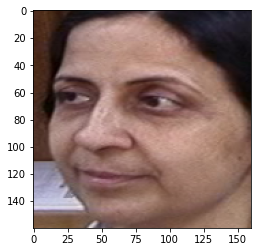

In [18]:
im = tf.cast(trainX[0], tf.int32)
plt.imshow(im)
plt.show()

#Building the Classifier

In [19]:
from sklearn.preprocessing import OneHotEncoder
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(trainy)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [20]:
onehot_encoded[0].shape

(51,)

In [21]:
train_datagenerator = ImageDataGenerator()
test_datagenerator = ImageDataGenerator()
train_datagenerator = train_datagenerator.flow(
    trainX,
    y = onehot_encoded,
    batch_size=8)

# test_datagenerator = test_datagenerator.flow_from_directory(
#     '/content/drive/MyDrive/face_data/val',
#     target_size=(256,256),
#     batch_size=10)

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', input_shape=(160,160,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((3,3)), 

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((3,3)),      
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    
    tf.keras.layers.Dense(51, activation='softmax')
])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9078 (Conv2D)         (None, 160, 160, 8)       224       
_________________________________________________________________
max_pooling2d_4542 (MaxPooli (None, 80, 80, 8)         0         
_________________________________________________________________
conv2d_9079 (Conv2D)         (None, 80, 80, 16)        1168      
_________________________________________________________________
max_pooling2d_4543 (MaxPooli (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_9080 (Conv2D)         (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d_4544 (MaxPooli (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1514 (Flatten)       (None, 2048)             

In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
             metrics=['accuracy'])

In [32]:
model.fit_generator(
    train_datagenerator,
    epochs=5,
    )

Epoch 1/5
 1/95 [..............................] - ETA: 10s - loss: 0.0274 - accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


95/95 [==============================] - 10s 110ms/step - loss: 0.2431 - accuracy: 0.9458
Epoch 2/5
95/95 [==============================] - 11s 111ms/step - loss: 0.0475 - accuracy: 0.9868
Epoch 3/5
95/95 [==============================] - 11s 111ms/step - loss: 0.0328 - accuracy: 0.9934
Epoch 4/5
95/95 [==============================] - 10s 110ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 5/5
95/95 [==============================] - 10s 110ms/step - loss: 7.9126e-04 - accuracy: 1.0000


In [33]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

In [36]:
target = 93
trainy[93]

's04'

float32
4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


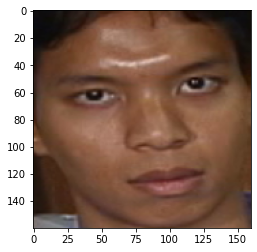

In [38]:
x = image.img_to_array(trainX[target])
x = np.expand_dims(x, axis=0)
classes = model.predict_proba(x)
print(np.argmax(classes)+1)
im = tf.cast(trainX[target], tf.int32)
plt.imshow(im)
plt.show()

#FGSM FUNCTION

In [46]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  im = tf.cast(signed_grad[0], tf.uint32)
  plt.imshow(im)
  plt.show()
  return signed_grad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


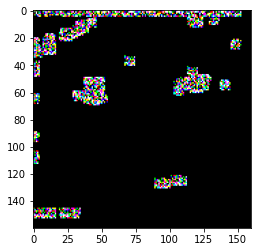

In [47]:
image = tf.cast(trainX[target], tf.float32)
image = image[None, ...]
labrador_retriever_index = argmax(onehot_encoded[target])
perturbations = create_adversarial_pattern(image, [onehot_encoded[target]])

#RESULTS

In [48]:
adv_x = image + 5*perturbations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


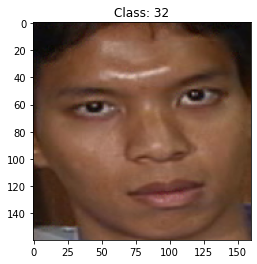

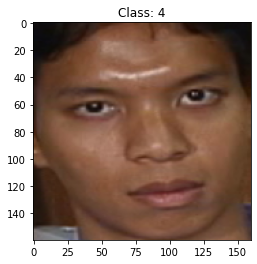

In [53]:
plt.figure()
im = tf.cast(adv_x, tf.int32)
plt.imshow(im[0])  # To change [-1, 1] to [0,1]
image_probs = model.predict(adv_x)
plt.title('Class: ' + str(np.argmax(image_probs)+1))
plt.show()

im = tf.cast(image, tf.int32)
image_probs = model.predict(im)
plt.imshow(im[0])
plt.title('Class: ' + str(np.argmax(image_probs)+1))
plt.show()